In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"


In [2]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
bombingOperations = spark.read.json("Bombing_Operations.json.gz")
aircraftGlossary = spark.read.json("Aircraft_Glossary.json")

In [6]:
#1.A DataFrame API
missionCounts = bombingOperations.groupBy("ContryFlyingMission")\
                                    .agg(count("*").alias("missionCount"))\
                                    .sort(desc("missionCount"))
missionCounts.show()

+--------------------+------------+
| ContryFlyingMission|missionCount|
+--------------------+------------+
|UNITED STATES OF ...|     3708997|
|     VIETNAM (SOUTH)|      622013|
|                LAOS|       32777|
|       KOREA (SOUTH)|       24469|
|           AUSTRALIA|       12519|
+--------------------+------------+



In [7]:
#1.B Spark SQL
bombingOperations.createOrReplaceTempView("Bombing_Operations")

In [8]:
query = """
SELECT ContryFlyingMission, count(*) as missionCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY missionCount DESC
"""

In [9]:
missionCounts_SQL = spark.sql(query)
missionCounts_SQL.show()

+--------------------+------------+
| ContryFlyingMission|missionCount|
+--------------------+------------+
|UNITED STATES OF ...|     3708997|
|     VIETNAM (SOUTH)|      622013|
|                LAOS|       32777|
|       KOREA (SOUTH)|       24469|
|           AUSTRALIA|       12519|
+--------------------+------------+



In [12]:
#2 - Bar Chart
missionCounts_pd = missionCounts_SQL.toPandas()

Text(0.5, 1.0, 'Missions by Each Country')

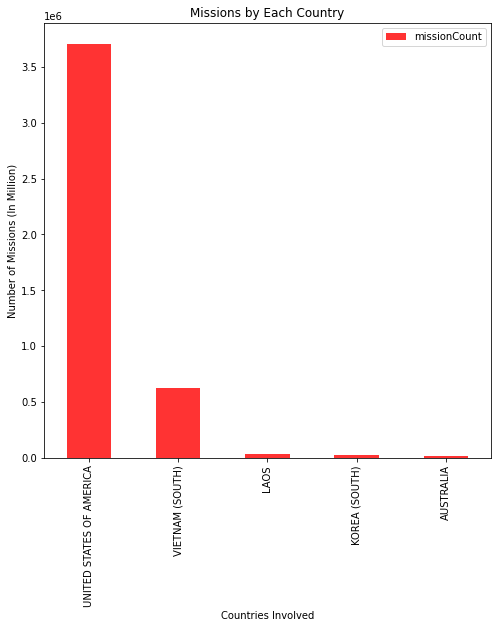

In [11]:
pl = missionCounts_pd.plot(kind="bar",
                            x="ContryFlyingMission", y="missionCount",
                            figsize=(8, 8), alpha=0.8, color="red")
pl.set_xlabel("Countries Involved")
pl.set_ylabel("Number of Missions (In Million)")
pl.set_title("Missions by Each Country")

In [14]:
# 3- Plot number of missions
countriesInvolved = bombingOperations.selectExpr(["to_date(MissionDate) as Date", "ContryFlyingMission"])

In [15]:
missionsPerDay = countriesInvolved\
                  .groupBy(["Date", "ContryFlyingMission"])\
                  .agg(count("*").alias("missionCount"))\
                  .sort(asc("Date")).toPandas()

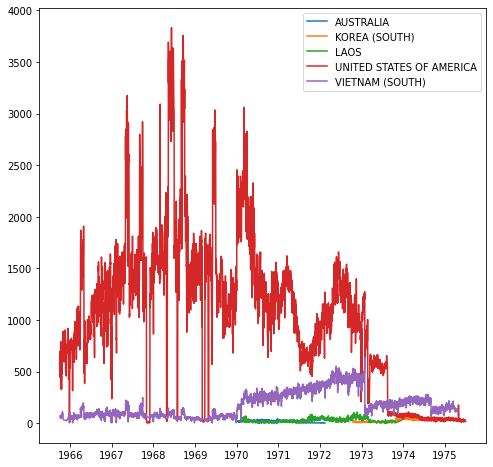

In [16]:
fig = plt.figure(figsize=(8, 8))

for country, missions in missionsPerDay.groupby("ContryFlyingMission"):
    plt.plot(missions["Date"], missions["missionCount"], label=country)
plt.legend(loc='best')

In [17]:
#4 - North Vietnam Attacks 6/29/1966
operationsInJune = bombingOperations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM'")

In [18]:
operationsInJune.groupBy("ContryFlyingMission")\
                .agg(count("*")\
                .alias("missionCount")).toPandas()

,ContryFlyingMission,missionCount
0,VIETNAM (SOUTH),6
1,UNITED STATES OF AMERICA,389


In [19]:
takeoffCounts = operationsInJune\
                            .groupBy("TakeoffLocation").agg(count("*").alias("missionCount"))\
                            .sort(desc("missionCount")).show()

+----------------+------------+
| TakeoffLocation|missionCount|
+----------------+------------+
|   CONSTELLATION|          87|
|          TAKHLI|          56|
|           KORAT|          55|
|        UDORN AB|          44|
|         UBON AB|          44|
|          RANGER|          35|
|          DANANG|          35|
|    TAN SON NHUT|          26|
|HANCOCK (CVA-19)|          10|
|    CAM RANH BAY|           2|
|         CUBI PT|           1|
+----------------+------------+



In [34]:
#5 - Month that saw the highest number of missions
bombingOperations.createOrReplaceTempView("Bombing_Operations2")

In [32]:
query2 = """
SELECT MONTH(MissionDate) as Month, count(*) as missionCount
FROM Bombing_Operations2
GROUP BY MONTH(MissionDate)
ORDER BY missionCount DESC
LIMIT 1
"""

In [33]:
missionsByMonth = spark.sql(query2)
missionsByMonth.show()

+-----+------------+
|Month|missionCount|
+-----+------------+
|    5|      457431|
+-----+------------+



In [20]:
#6 - heaviest bombings; showed top 3 as operation supported is None (null) for most of the rows
heaviestBombings = bombingOperations.groupBy("OperationSupported")\
                                    .agg(count("*").alias("missionCount"))\
                                    .sort(desc("missionCount"))\
                                    .limit(3)

heaviestBombings.show()

+--------------------+------------+
|  OperationSupported|missionCount|
+--------------------+------------+
|                null|     1839788|
|          IN COUNTRY|      546215|
|IN COUNTRY - SOUT...|      200616|
+--------------------+------------+



In [21]:
#7 - Most used aircraft type
aircraft_bombing = bombingOperations.join(aircraftGlossary,
                                          bombingOperations.AirCraft == aircraftGlossary.AirCraft)

In [22]:
aircrafts = aircraft_bombing.select("AirCraftType")

In [23]:
aircrafts.groupBy("AirCraftType")\
        .agg(count("*")\
        .alias("missionCount"))\
        .sort(desc("missionCount"))\
        .limit(1)\
        .show()

+------------------+------------+
|      AirCraftType|missionCount|
+------------------+------------+
|Fighter Jet Bomber|     1073126|
+------------------+------------+

